In [1]:
import sys
import os
import cv2
import numpy as np
import shutil
from IPython.display import Image as img_display

In [2]:
pathname='./resources' #os.path.dirname(sys.argv[0])
file=os.path.join(pathname,'fax1',"fax1.png") # deep1.png

In [3]:
def apply_blur(img,ksize=(3,3),sigmaX=0,sigmaY=0,borderType=cv2.BORDER_DEFAULT):
    """
    Args:
        img:       input image matrix
        ksize:     Gaussian kernel size. ksize.width and ksize.height can differ but they both must be positive and odd. 
                   Or, they can be zero's and then they are computed from sigma.
        sigmaX:    Gaussian kernel standard deviation in X direction
        sigmaY:    Gaussian kernel standard deviation in Y direction; 
                   if sigmaY is zero, it is set to be equal to sigmaX, if both sigmas are zeros, they are computed from ksize.
                   width and ksize.height, respectively (see cv::getGaussianKernel for details); to fully control the result 
                   regardless of possible future modifications of all this semantics, it is recommended to specify all of ksize, 
                   sigmaX, and sigmaY.
        borderType:pixel extrapolation method, see cv::BorderTypes
    """
    localpath=os.path.join(pathname,"blur.png")
    img=cv2.GaussianBlur(img,ksize,sigmaX,sigmaY,borderType) # cv2.GaussianBlur(img,(3,3),0)
    cv2.imwrite(localpath,img)
    return (img,localpath)

In [4]:
def invert_color(img):
    localpath=os.path.join(pathname,"bitwise.png")
    img=cv2.bitwise_not(img)
    cv2.imwrite(localpath,img)
    return (img,localpath)

In [5]:
def clean_noise(img,ksize=(1,1),iterations=1):
    """
    Args:
        ksize: kernel size
        iterations:
    """
    localpath=os.path.join(pathname,"removed_noise.png")
    kernel = np.ones(ksize,np.uint8)
    img=cv2.dilate(img,kernel,iterations=iterations)
    img=cv2.erode(img,kernel,iterations=iterations)
    cv2.imwrite(localpath,img)
    return (img,localpath)

In [6]:
def apply_bightness(img):
    localpath=os.path.join(pathname,"brightness.png")
    for x in range(0, len(img)):
        for y in range(0, len(img[x])):
            if img[x,y]<255:
                img[x, y]=0
    cv2.imwrite(localpath,img)
    return (img, localpath)

In [7]:
def apply_threshold(img): 
    localpath=os.path.join(pathname,"thres.png")
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,3,1)
    ret,thresh = cv2.threshold(img,127,255,0)
    cv2.imwrite(localpath,img)
    return (img,localpath)

In [8]:
def run_mser(img,org_img,delta=5,min_area=60,max_area=14400,max_variation=0.25,
             min_diversity=0.2,max_evolution=200,area_threshold=1.01,min_margin=0.003,edge_blur_size=5):
    """
    delta:          it compares (sizei−size'i−delta')/size'i−delta'
    min_area:       prune the area which smaller than minArea
    max_area:       prune the area which bigger than maxArea
    max_variation:  prune the area have simliar size to its children
    min_diversity:  for color image, trace back to cut off mser with diversity less than min_diversity
    max_evolution:  for color image, the evolution steps
    area_threshold: for color image, the area threshold to cause re-initialize
    min_margin:     for color image, ignore too small margin
    edge_blur_size: for color image, the aperture size for edge blur
    """
    localpath=os.path.join(pathname,"linesImg.png")
    # mser = cv2.MSER_create(1,25,200)
    mser = cv2.MSER_create(delta,min_area,max_area,max_variation)# cv2.MSER_create(1,20,80,1)
    regions,_ = mser.detectRegions(img)
    rects=[cv2.boundingRect(p.reshape(-1,1,2)) for p in regions]
    linesImg=org_img.copy()
    for i,rect in enumerate(rects):
        cv2.rectangle(linesImg,rect[0:2],(rect[0]+rect[2],rect[1]+rect[3]),(0,255,0),1)
    cv2.imwrite(localpath,linesImg)
    return (rects,localpath)

In [9]:
def draw_black_block(img,rects,f_enable=True,f_length_scale=1,f_shape_scale=7.0):
    """
    f_enable: if True turns on filter
    f_length_scale: the min length on width and height
    f_shape_scale: the max shape
    """
    localpath=os.path.join(pathname,"filled.png")
    for i,rect in enumerate(rects):
        width=rect[2]
        height=rect[3]
        if not f_enable or (width>f_length_scale and height>f_length_scale and (width/height<f_shape_scale) and (height/width<f_shape_scale)):
            #print(str(width)+" "+str(height))
            #cv2.rectangle(gray,(0,0),(10,20),(0,255,0),2)
            offset=0
            (top,left)=(rect[0]-offset,rect[1]-offset)
            cv2.rectangle(img,(top,left),(rect[0]+rect[2]+2*offset,rect[1]+rect[3]+2*offset),(0,0,0),-1)
    
    cv2.imwrite(localpath,img)
    return (img,localpath)

In [10]:
def detect_chars(img,org_img,f_enable=True,f_length_scale=1.0,f_shape_scale=6,f_area=100):
    localpath=os.path.join(pathname,"result.png")
    # detect black blocks
    bgr=cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    img=cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    # colours=['yellow','orange','red','green','black','white']
    # lowers=[[30,255,255],[15,255,255],[6,255,255],[0,0,0],[0, 0, 205]]
    # uppers=[[20,100,100],[5,100,100],[0,100,100],[180, 10, 50],[180, 10, 255]]

    lower=np.array([0, 0, 0],np.uint8)
    upper=np.array([180, 10, 50],np.uint8)
    separated=cv2.inRange(img,lower,upper)

    #this bit draws a red rectangle around the detected region 
    im2,contours,hierarchy=cv2.findContours(separated,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE) 
    max_area = 0 
    largest_contour = None
    outImg=org_img.copy()
    # the total number of corp chars
    total_corps=0
    # the number of corp single chars 
    single_corps=0
    # the output path of corp chars
    corp_chars_path=os.path.join(pathname,"corp_chars_fix")
    # the output path of single chars
    single_path=os.path.join(corp_chars_path,"singles")
    # the scalar of single char
    single_scalar=1.8
    if not os.path.exists(corp_chars_path):
        os.makedirs(corp_chars_path)
    else:
        shutil.rmtree(corp_chars_path)
    if not os.path.exists(single_path):
        os.makedirs(single_path)
    else:
        shutil.rmtree(single_path)

    for idx, contour in enumerate(contours): 
        area = cv2.contourArea(contour) 
        # if area > max_area: 
        max_area = area 
        largest_contour=contour 
        if largest_contour is not None:
            moment = cv2.moments(largest_contour) 
            rect = cv2.boundingRect(largest_contour)
            (height,width)=(rect[2],rect[3])
            area=cv2.contourArea(largest_contour)
            if not f_enable or (height>f_length_scale and width>f_length_scale and ((width/height)<f_shape_scale) and ((height/width)<f_shape_scale) and area>f_area):
                # print(cv2.contourArea(largest_contour))
                total_corps+=1
                x,y,w,h = rect
                offset=0
                cropped = outImg[y:y+h,x:x+w]
                outfile=""
                if (width/height>=1.0 and width/height<=single_scalar) or (height/width>=1.0 and height/width<=single_scalar):
                    single_corps+=1
                    outfile=os.path.join(single_path, "{0}_{1}_{2}_{3}_{4}.png".format(idx,x,y,w,h))
                else:
                    outfile=os.path.join(corp_chars_path, "{0}_{1}_{2}_{3}_{4}.png".format(idx,x,y,w,h))
                cv2.imwrite(outfile,cropped)
                cv2.rectangle(org_img,(x-offset,y-offset),(x+w+2*offset,y+h+2*offset),(0,255,0),1)

    print("total {0} chars, {1} single chars, output rate {2:0.3f}%".format(total_corps,single_corps,single_corps/total_corps*100))
    cv2.imwrite(localpath,org_img)
    return localpath

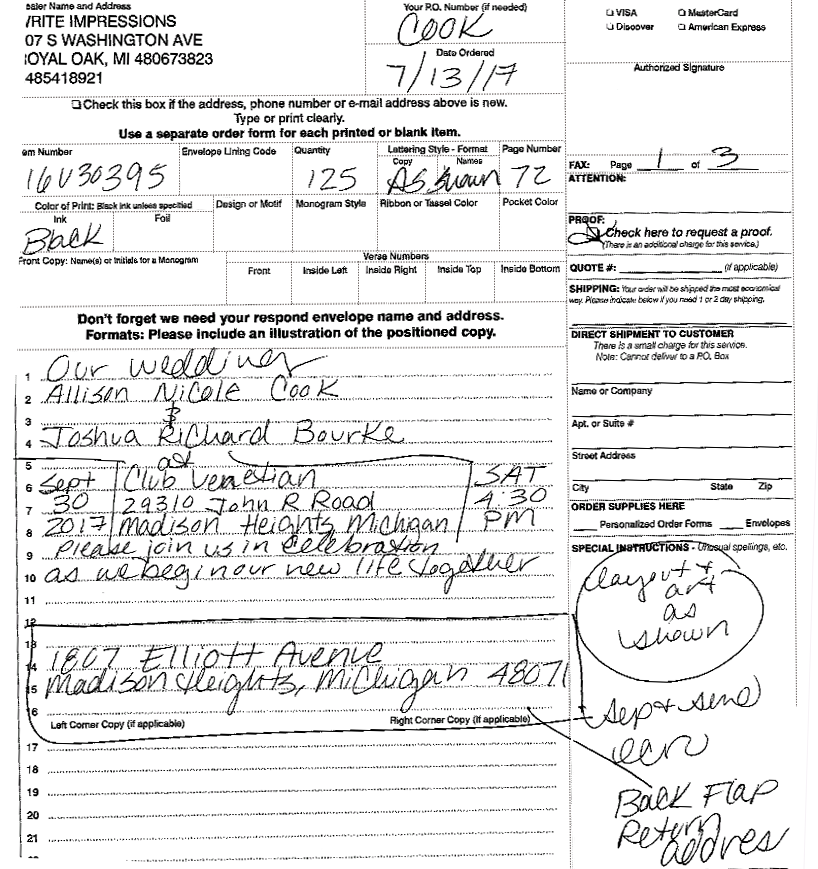

In [11]:
img = cv2.imread(file)
gray= cv2.imread(file,0)
# display in IPython
img_display(filename=file)

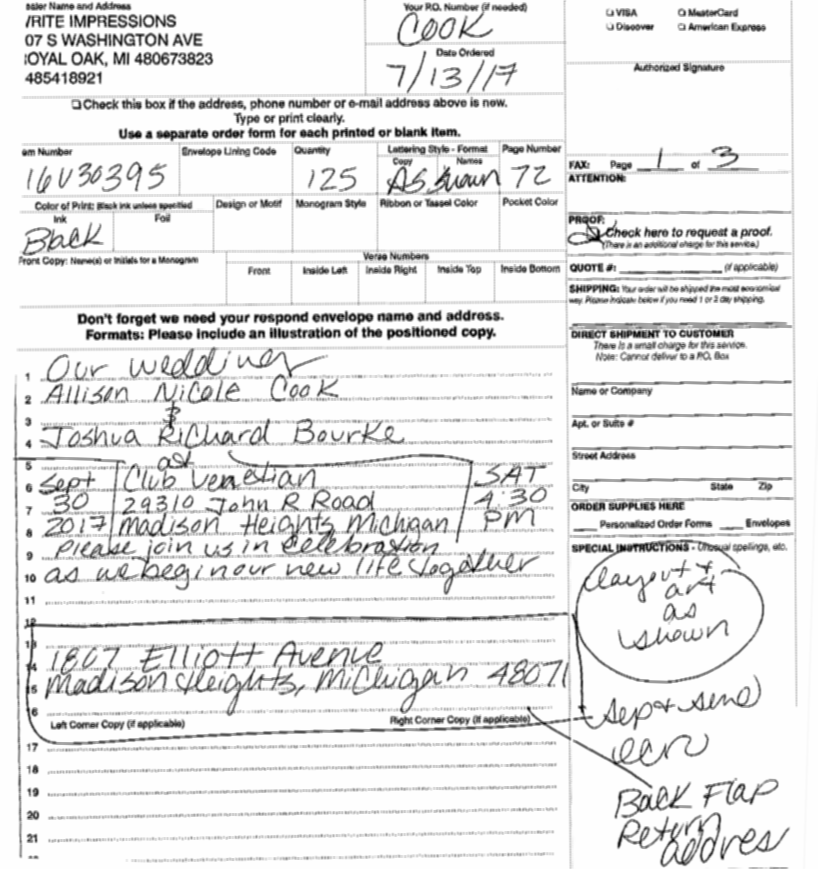

In [12]:
# apply blur
ksize=(3,3)
sigmaX=0
sigmaY=0
gray, filename=apply_blur(gray,ksize,sigmaX,sigmaY)
img_display(filename=filename)

In [13]:
# invert color
# gray,filename=invert_color(gray)
# img_display(filename=filename)

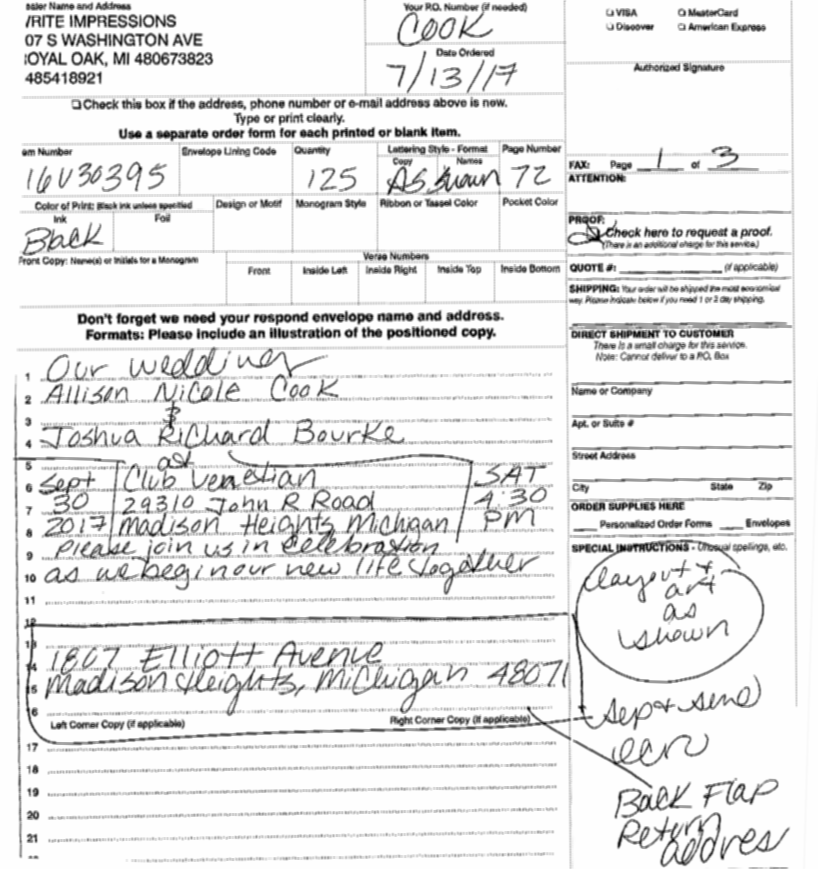

In [14]:
# Apply dilation and erosion to remove some noise
ksize=(1,1)
iteration=1
gray,filename=clean_noise(gray,ksize,iteration)
img_display(filename=filename)

In [15]:
# bightness
# gray,filename=apply_bightness(gray)
# img_display(filename=filename)

In [16]:
# Apply threshold to get image with only black and white
#gray,filename = apply_threshold(gray)
#img_display(filename=filename)

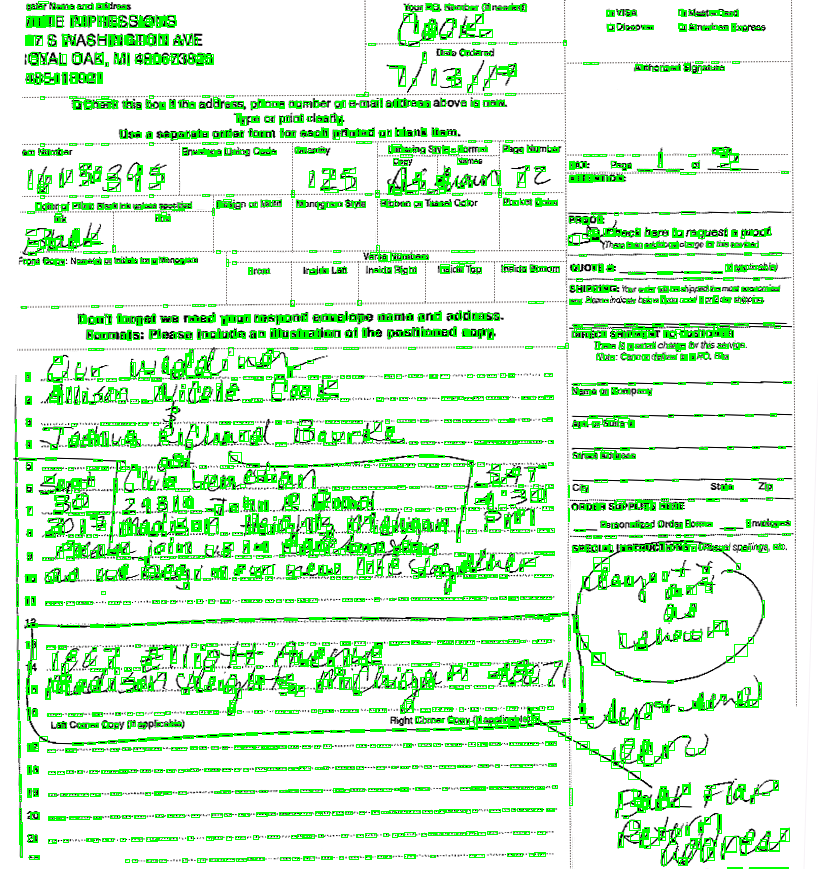

In [17]:
# MSER to detect regions
delta=1         # 5
min_area=10     # 60
max_area=30     # 14400
max_variation=0.1 # 0.25
rects,filename=run_mser(gray,img,delta,min_area,max_area,max_variation)
img_display(filename=filename)

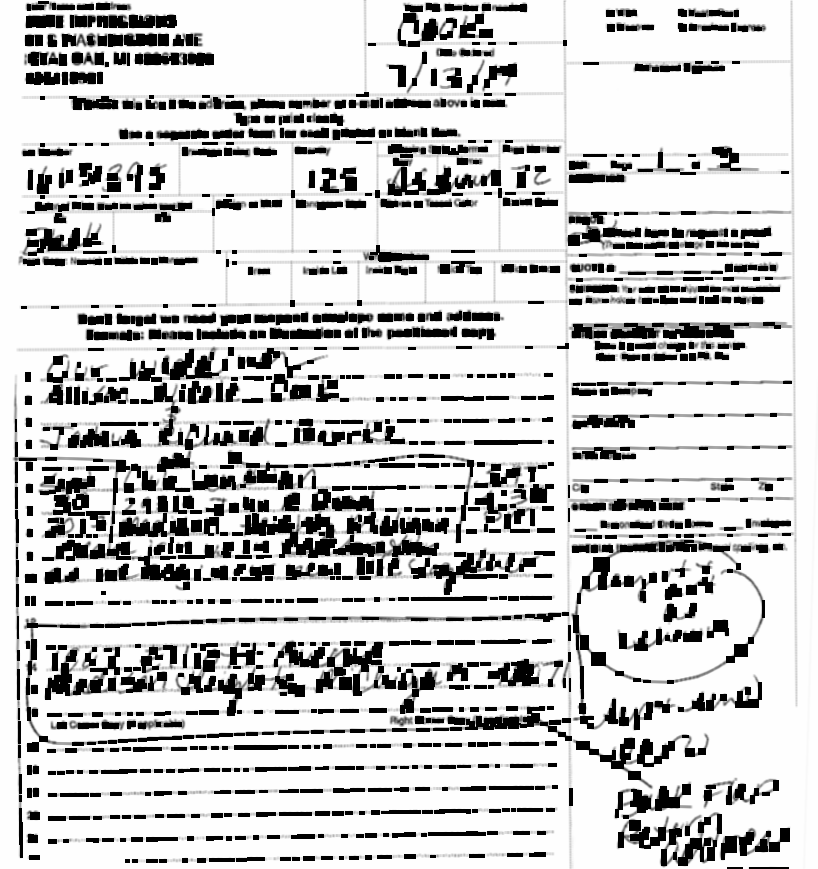

In [18]:
# draw rectangles
f_enable=False
f_length_scale=1
f_shape_scale=7.0
gray,filename=draw_black_block(gray,rects,f_enable,f_length_scale,f_shape_scale)
img_display(filename=filename)

total 1409 chars, 672 single chars, output rate 47.693%


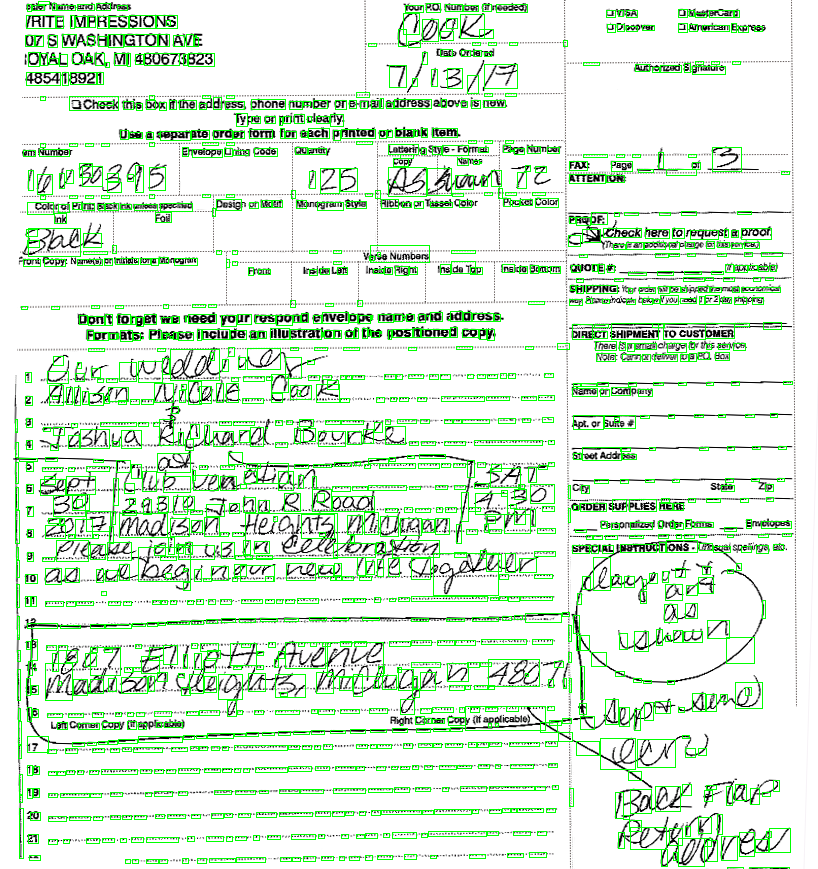

In [19]:
# detect black blocks
f_enable=False
f_length_scale=1.0
f_shape_scale=6
f_area=100
filename=detect_chars(gray,img,f_enable,f_length_scale,f_shape_scale,f_area)
img_display(filename=filename)